In [127]:
import torch
from einops import rearrange, repeat
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
from typing import List, Tuple, Dict
import seaborn as sns
from tqdm.auto import trange, tqdm

#kernels_out_mi_no_pool are from gentimmkernels.py

def load_kernel_files(directory="kernels_out"):
    """
    Load all .pt files from the specified directory.
    
    Args:
        directory (str): Directory containing kernel files
        
    Returns:
        dict: Dictionary mapping filenames to loaded kernel data
    """
    kernel_files = glob.glob(os.path.join(directory, "*.pt"))
    kernels = []
    names = []
    for file_path in tqdm(kernel_files):
        try:
            kernel_data = torch.load(file_path)

            K = kernel_data['K'].cuda() # this is the cosine kernel

            n = K.shape[0]
            ones = torch.ones(n, 1, device=K.device)
            H = torch.eye(n, device=K.device) - (1/n) * (ones @ ones.T)
            kernel = H @ K @ H
            #kernel = K
            #Fro norm
            kernel = kernel / torch.linalg.norm(kernel)

            #Trace norm
            #kernel = kernel / torch.trace(kernel)
            #kernel = kernel / torch.linalg.norm(kernel, ord='nuc')
            
            kernels.append(kernel.cpu())
            file_name = Path(file_path).stem
            file_name = file_name.replace('K_', '')
            if '__' in file_name:
                org, model = file_name.split('__', 1)
                if model.endswith('_8192'):
                    model = model[:-5]
                file_name = f"{org}/{model}"
            
            names.append(file_name)

        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    print(f"Loaded {len(kernels)} kernel files from {directory}")
    return kernels, names

# Load all kernel files
kernels, names = load_kernel_files()

  0%|          | 0/26 [00:00<?, ?it/s]

/tmp/ipykernel_29838/2860413603.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kernel_data = torch.load(file_path)


Loaded 26 kernel files from kernels_out


In [128]:
def compute_expectation_variance(K: torch.Tensor,
                                 M: torch.Tensor,
                                 T: float = 1.0) -> Tuple[torch.Tensor,
                                                          torch.Tensor]:
    """Return Σ M σ and Σ M² σ(1‑σ) with σ = sigmoid(K/T)."""
    sigma       = torch.sigmoid(K / T)
    expectation = (M * sigma).sum()
    variance    = ((M**2) * sigma * (1 - sigma)).sum()
    return expectation, variance

In [129]:
import seaborn as sns

T = 0.00001
expectations = np.zeros((len(kernels), len(kernels)))
variances = np.zeros((len(kernels), len(kernels)))
for i in trange(len(kernels)):
    for j in range(len(kernels)):
        K = kernels[i].cuda()
        M = kernels[j].cuda()
        expectation, variance = compute_expectation_variance(K, M, T)
        expectations[i, j] = expectation.cpu()
        variances[i, j] = variance.cpu()

  0%|          | 0/26 [00:00<?, ?it/s]

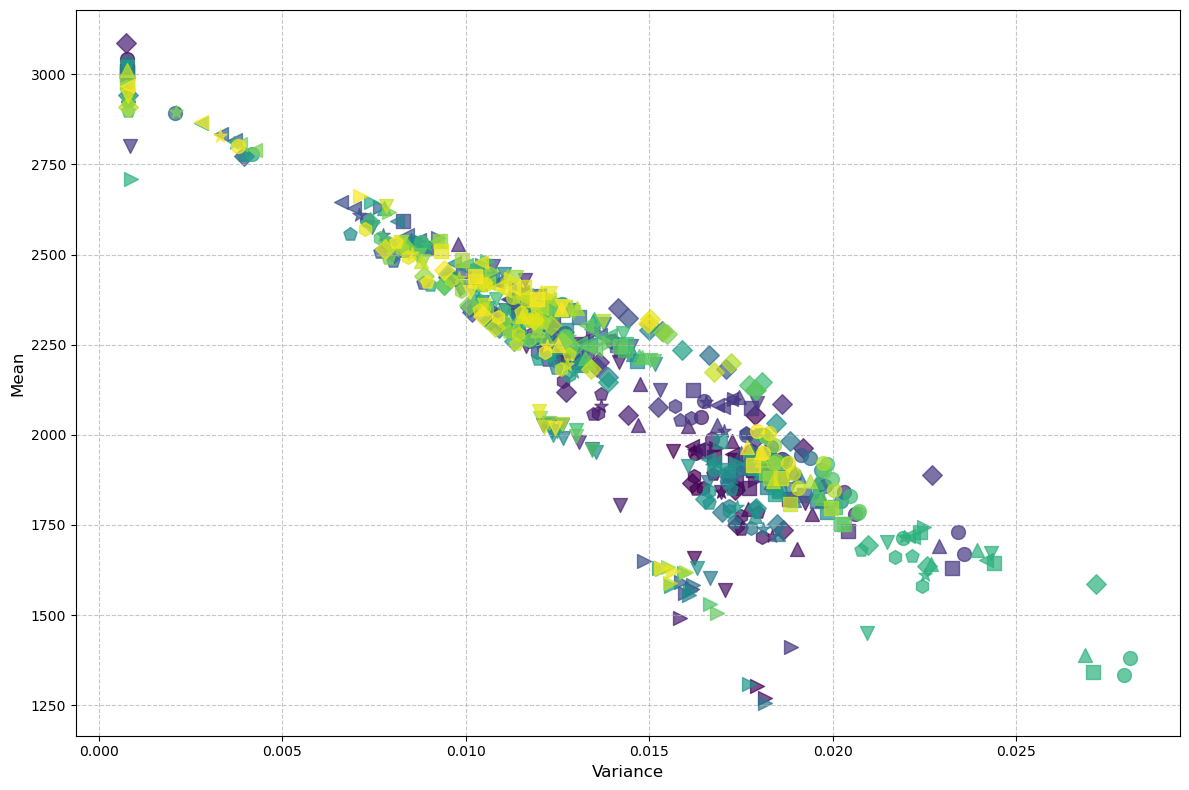

In [130]:
plt.figure(figsize=(12, 8))

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']
colors = plt.cm.viridis(np.linspace(0, 1, len(kernels)))

plotted_K = set()
plotted_M = set()

for K_idx in range(len(kernels)):
    for M_idx in range(len(kernels)):
        y_val = expectations[K_idx, M_idx]
        x_val = variances[K_idx, M_idx]
        
        k_label = f"K: {names[K_idx]}" if names[K_idx] not in plotted_K else None
        if k_label:
            plotted_K.add(names[K_idx])
        
        plt.scatter(x_val, y_val, 
                    s=100,
                    color=colors[K_idx],
                    marker=markers[M_idx % len(markers)],
                    alpha=0.7,
                    label=k_label)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker=markers[i % len(markers)], color='gray', 
                         label=f"M: {names[i]}", markersize=10, linestyle='None')
                  for i in range(len(names))]

#first_legend = plt.legend(title="Kernel K (color)", bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.gca().add_artist(first_legend)

#plt.legend(handles=legend_elements, title="Kernel M (marker)", 
#           bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.ylabel('Mean', fontsize=12)
plt.xlabel('Variance', fontsize=12)
#plt.title('Relationship Between Variance and Expectation\nfor Different Kernel Combinations', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

#save to pdf
plt.savefig("kernel_expectation_variance_comparision2.pdf", dpi=300, bbox_inches='tight')

plt.show()


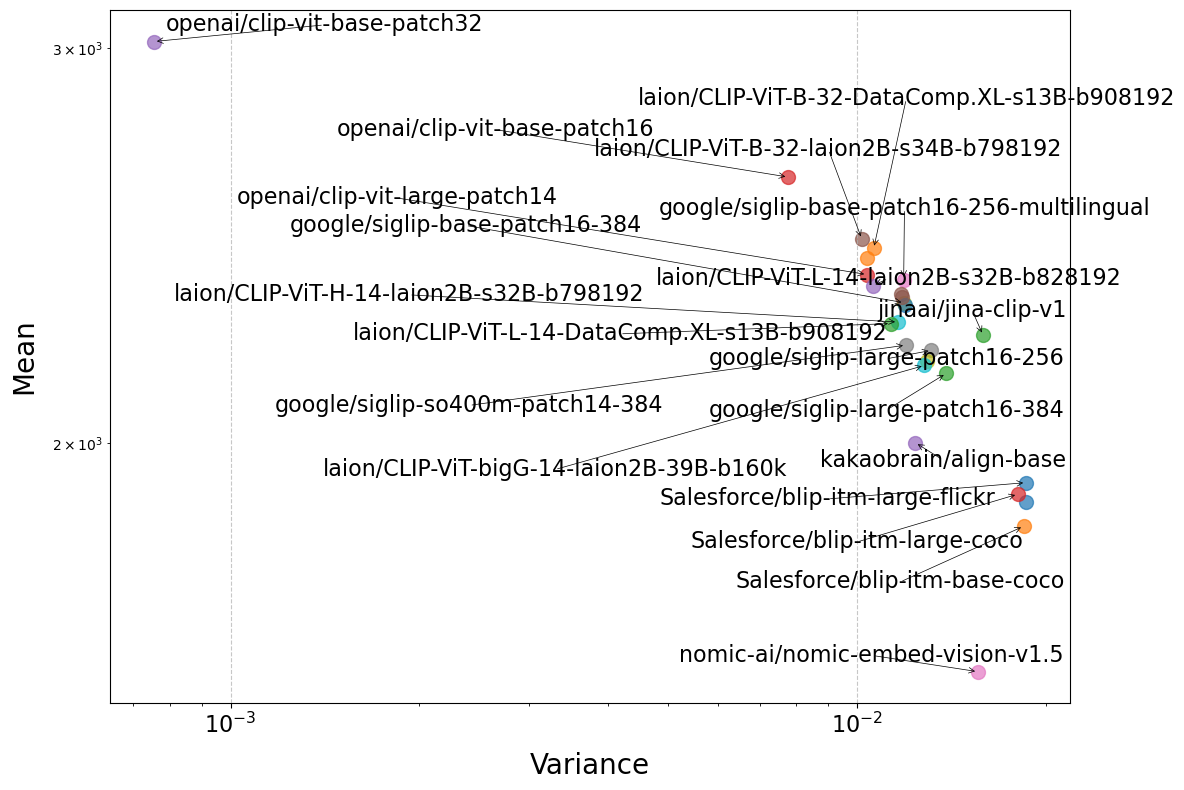

openai/clip-vit-base-patch32


In [131]:
plt.figure(figsize=(12,8))

markers = ['o']
colors = plt.cm.viridis(np.linspace(0, 1, len(kernels)))

plotted_K = set()
plotted_M = set()

from adjustText import adjust_text
texts = []

K_idx = 14

# Control whether to drop dense labels or not
drop_dense_labels = True  # Set to False to show all labels

label_min_dist = 0.01  # in log-log space, tweak as needed
labeled_points = []

for M_idx in range(len(kernels)):
    y_val = expectations[K_idx, M_idx]
    x_val = variances[K_idx, M_idx]
    
    m_label = f"M: {names[M_idx]}" if names[M_idx] not in plotted_M else None
    if m_label:
        plotted_M.add(names[M_idx])
    
    plt.scatter(x_val, y_val, 
                s=100,
                marker=markers[K_idx % len(markers)],
                alpha=0.7,
                label=m_label)
    
    add_label = True
    if drop_dense_labels:
        # Only add a label if not too close to an already-labeled point
        log_x, log_y = np.log10(x_val), np.log10(y_val)
        for px, py in labeled_points:
            if np.hypot(log_x - px, log_y - py) < label_min_dist:
                add_label = False
                break
    # If not dropping dense labels, always add
    if add_label:
        model_name = names[M_idx].replace('K_', '').replace('_8192', '')
        texts.append(plt.text(x_val, y_val, model_name, fontsize=16))
        if drop_dense_labels:
            labeled_points.append((np.log10(x_val), np.log10(y_val)))
    # else: skip label for this point

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker=markers[K_idx % len(markers)], color='gray', 
                         label=f"K: {names[K_idx]}", markersize=14, linestyle='None')]  # Increased markersize

#first_legend = plt.legend(title="Kernel M (color)", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, title_fontsize=18)  # Increased fontsize
#plt.gca().add_artist(first_legend)

plt.ylabel('Mean', fontsize=20, labelpad=10)
plt.xlabel('Variance', fontsize=20, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

plt.yscale('log')
plt.xscale('log')

if texts:
    adjust_text(texts, 
                arrowprops=dict(arrowstyle='->', color='black', lw=0.5),
                expand_points=(3.0, 3.0),
                force_points=(1.0, 1.0),
                force_text=(1.0, 1.0),
                only_move={'points':'xy', 'text':'xy'},
                fontsize=16)  # Increased fontsize for adjust_text
plt.savefig('kernel_variance_expectation_dropped.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()
print(names[K_idx])


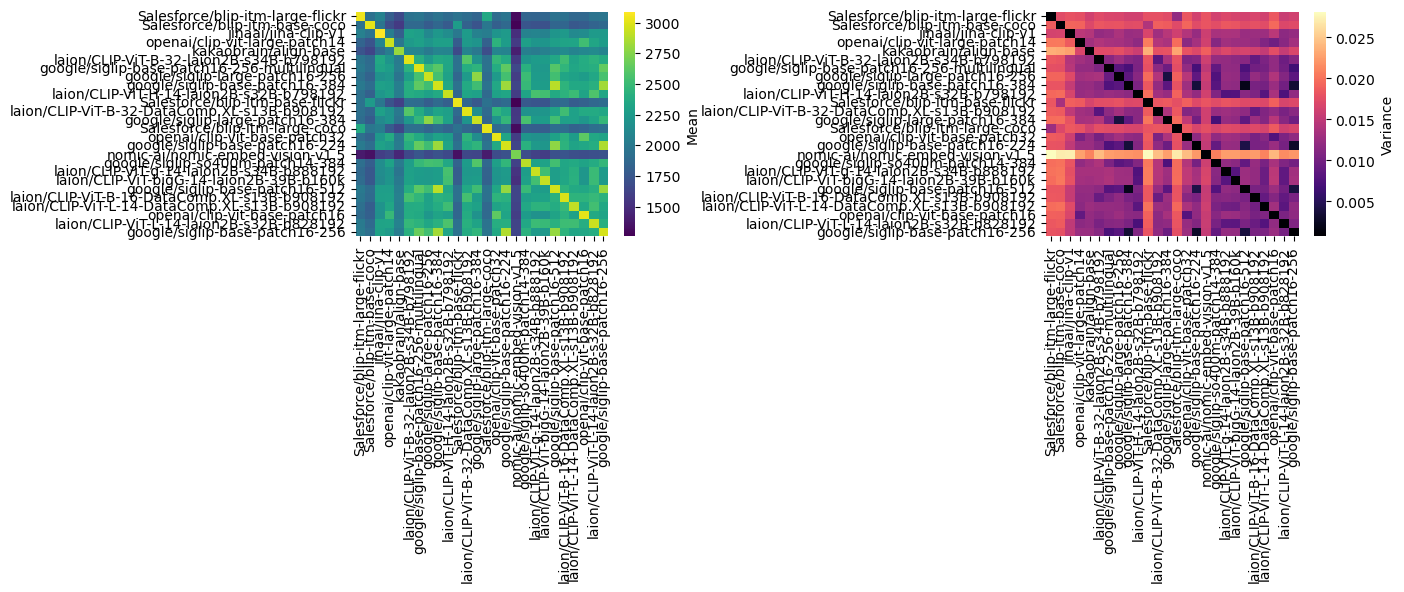

In [132]:
plt.figure(figsize=(14, 6))

# Expectation heatmap
plt.subplot(1, 2, 1)
sns.heatmap(expectations,
            xticklabels=names,
            yticklabels=names,
            cmap='viridis',
            cbar_kws={'label': 'Mean'})
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Variance heatmap
plt.subplot(1, 2, 2)
sns.heatmap(variances,
            xticklabels=names,
            yticklabels=names,
            cmap='magma',
            cbar_kws={'label': 'Variance'})
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()

plt.savefig("kernel_comparision_heatmaps.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [133]:
names

['Salesforce/blip-itm-large-flickr',
 'Salesforce/blip-itm-base-coco',
 'jinaai/jina-clip-v1',
 'openai/clip-vit-large-patch14',
 'kakaobrain/align-base',
 'laion/CLIP-ViT-B-32-laion2B-s34B-b798192',
 'google/siglip-base-patch16-256-multilingual',
 'google/siglip-large-patch16-256',
 'google/siglip-base-patch16-384',
 'laion/CLIP-ViT-H-14-laion2B-s32B-b798192',
 'Salesforce/blip-itm-base-flickr',
 'laion/CLIP-ViT-B-32-DataComp.XL-s13B-b908192',
 'google/siglip-large-patch16-384',
 'Salesforce/blip-itm-large-coco',
 'openai/clip-vit-base-patch32',
 'google/siglip-base-patch16-224',
 'nomic-ai/nomic-embed-vision-v1.5',
 'google/siglip-so400m-patch14-384',
 'laion/CLIP-ViT-g-14-laion2B-s34B-b888192',
 'laion/CLIP-ViT-bigG-14-laion2B-39B-b160k',
 'google/siglip-base-patch16-512',
 'laion/CLIP-ViT-B-16-DataComp.XL-s13B-b908192',
 'laion/CLIP-ViT-L-14-DataComp.XL-s13B-b908192',
 'openai/clip-vit-base-patch16',
 'laion/CLIP-ViT-L-14-laion2B-s32B-b828192',
 'google/siglip-base-patch16-256']

In [134]:
import pandas as pd
avg_loaded = pd.read_csv('/home/user/BirthOfSSL/mieb_evals/Model_Benchmark_Avg.csv', index_col=0)
var_loaded = pd.read_csv('/home/user/BirthOfSSL/mieb_evals/Model_Benchmark_Var.csv', index_col=0)
# Get the overlap of avg_loaded.index and names, then filter and order by names
overlap = [n for n in names if n in avg_loaded.index]
avg_loaded_overlap = avg_loaded.loc[overlap]
var_loaded_overlap = var_loaded.loc[overlap]
print(len(avg_loaded_overlap))
mask = np.array([True if n in avg_loaded.index else False for n in names])
names_ = np.array(names)[mask]

19


In [135]:
expectations_ = expectations[np.ix_(mask, mask)]
variances_ = variances[np.ix_(mask, mask)]

In [136]:
for K_idx in range(sum(mask)):
    avgs = expectations_[K_idx]
    vars = variances_[K_idx]

    # Compute Pearson correlation between avgs/vars and avg_loaded_overlap/var_loaded_overlap for the current model
    import numpy as np

    avg_loaded_vals = avg_loaded_overlap.values.flatten()
    var_loaded_vals = var_loaded_overlap.values.flatten()

    # Compute Pearson correlation
    corr_avg = np.corrcoef(avgs, avg_loaded_vals)[0, 1]
    corr_var = np.corrcoef(vars, var_loaded_vals)[0, 1]

    print(f"Correlation for K_idx={K_idx}, {names_[K_idx]}:")
    print(f"  avgs vs avg_loaded_overlap: {corr_avg:.4f}")
    print(f"  vars vs var_loaded_overlap: {corr_var:.4f}")


Correlation for K_idx=0, Salesforce/blip-itm-large-flickr:
  avgs vs avg_loaded_overlap: -0.2639
  vars vs var_loaded_overlap: -0.5052
Correlation for K_idx=1, Salesforce/blip-itm-base-coco:
  avgs vs avg_loaded_overlap: -0.5378
  vars vs var_loaded_overlap: -0.2928
Correlation for K_idx=2, jinaai/jina-clip-v1:
  avgs vs avg_loaded_overlap: 0.0268
  vars vs var_loaded_overlap: 0.0390
Correlation for K_idx=3, openai/clip-vit-large-patch14:
  avgs vs avg_loaded_overlap: 0.5180
  vars vs var_loaded_overlap: 0.6443
Correlation for K_idx=4, kakaobrain/align-base:
  avgs vs avg_loaded_overlap: 0.2710
  vars vs var_loaded_overlap: 0.1789
Correlation for K_idx=5, google/siglip-base-patch16-256-multilingual:
  avgs vs avg_loaded_overlap: 0.5703
  vars vs var_loaded_overlap: 0.3816
Correlation for K_idx=6, google/siglip-large-patch16-256:
  avgs vs avg_loaded_overlap: 0.7341
  vars vs var_loaded_overlap: 0.5701
Correlation for K_idx=7, google/siglip-base-patch16-384:
  avgs vs avg_loaded_overlap

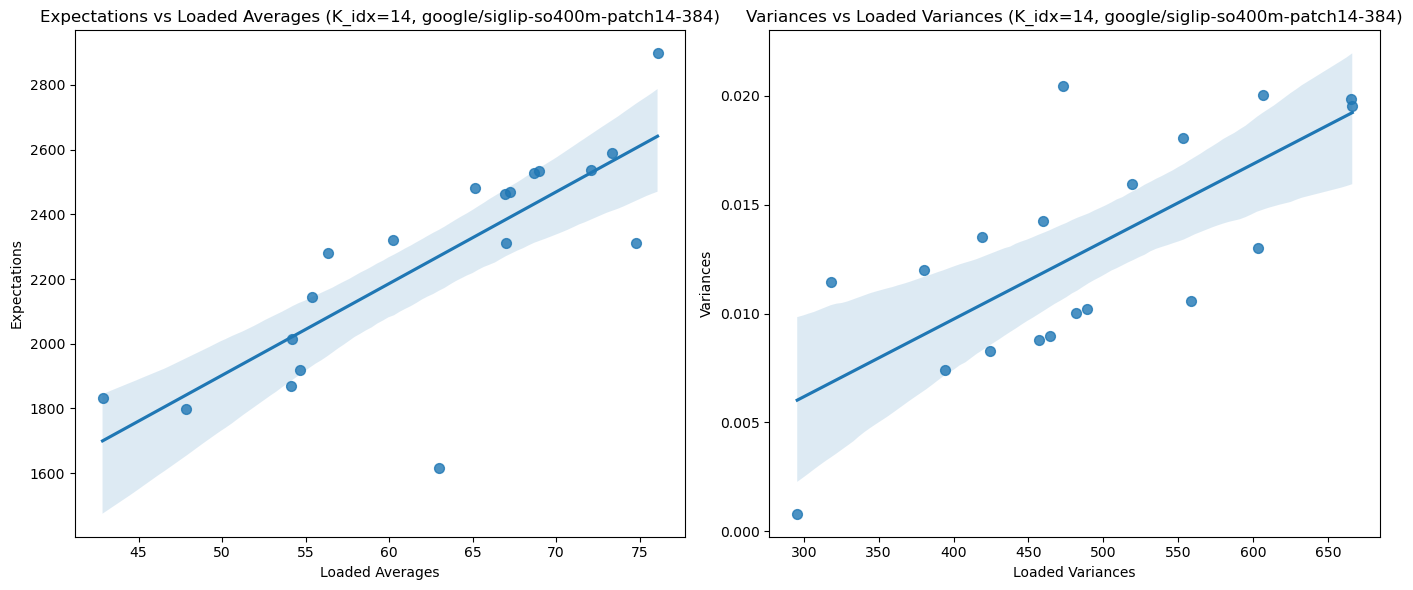

In [137]:
K_idx = 14
import matplotlib.pyplot as plt
import seaborn as sns

# Get the data for the selected K_idx
avgs = expectations_[K_idx]
vars_ = variances_[K_idx]

avg_loaded_vals = avg_loaded_overlap.values.flatten()
var_loaded_vals = var_loaded_overlap.values.flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot expectations vs loaded averages
sns.regplot(x=avg_loaded_vals, y=avgs, ax=axes[0], scatter_kws={'s': 50})
axes[0].set_title(f'Expectations vs Loaded Averages (K_idx={K_idx}, {names_[K_idx]})')
axes[0].set_xlabel('Loaded Averages')
axes[0].set_ylabel('Expectations')

# Plot variances vs loaded variances
sns.regplot(x=var_loaded_vals, y=vars_, ax=axes[1], scatter_kws={'s': 50})
axes[1].set_title(f'Variances vs Loaded Variances (K_idx={K_idx}, {names_[K_idx]})')
axes[1].set_xlabel('Loaded Variances')
axes[1].set_ylabel('Variances')

plt.tight_layout()
plt.show()


Correlation for K = mean(kernels_):
  exps vs avg_loaded_overlap: 0.5769
  vars vs var_loaded_overlap: 0.4826


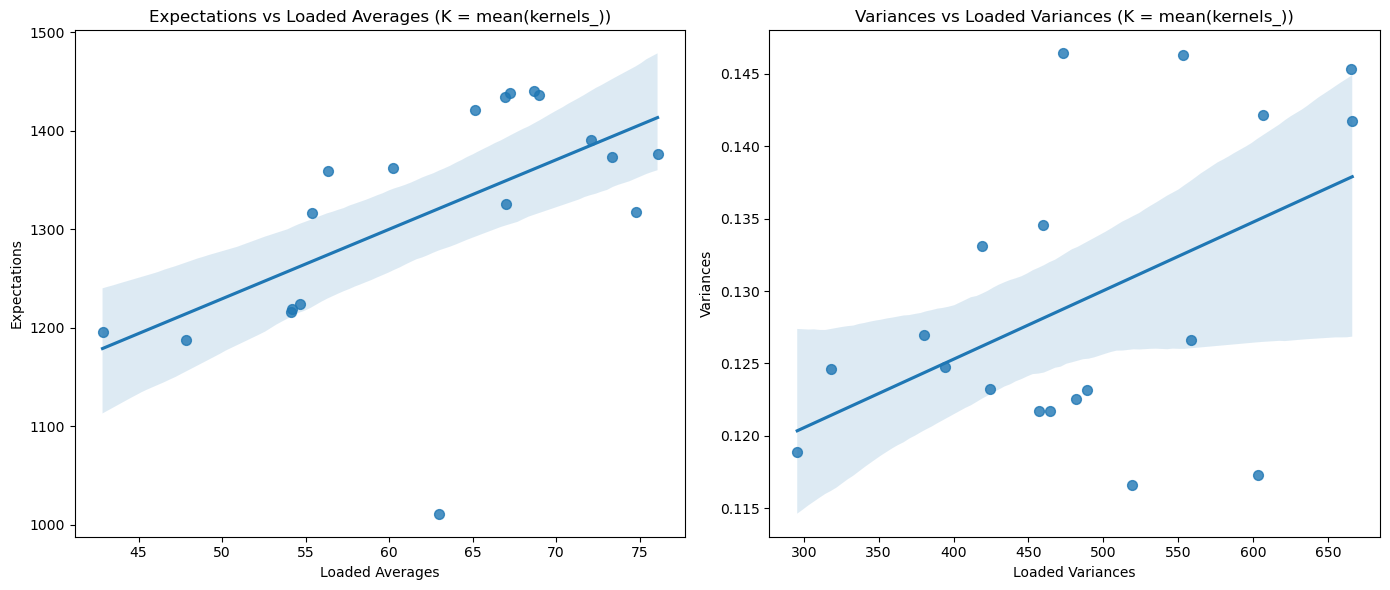

In [149]:
kernels_ = np.array(kernels)[mask]

# Compute the average kernel across the 0th dimension
K = np.mean(kernels_, axis=0)

# Compute expectations and variances for K vs every other kernel in kernels_
exps = []
vars_ = []
for i in range(kernels_.shape[0]):
    exp, var = compute_expectation_variance(torch.tensor(K), torch.tensor(kernels_[i]), T = 0.0001)
    exps.append(exp)
    vars_.append(var)
exps = np.array(exps)
vars_ = np.array(vars_)

# Flatten if needed (depends on compute_exp_and_var output shape)
exps_flat = exps.flatten()
vars_flat = vars_.flatten()

# For comparison, get the loaded overlap averages and variances (flattened)
avg_loaded_vals = avg_loaded_overlap.values.flatten()
var_loaded_vals = var_loaded_overlap.values.flatten()

# Compute Pearson correlation
corr_avg = np.corrcoef(exps_flat, avg_loaded_vals)[0, 1]
corr_var = np.corrcoef(vars_flat, var_loaded_vals)[0, 1]

print("Correlation for K = mean(kernels_):")
print(f"  exps vs avg_loaded_overlap: {corr_avg:.4f}")
print(f"  vars vs var_loaded_overlap: {corr_var:.4f}")

# Plot expectations vs loaded averages
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.regplot(x=avg_loaded_vals, y=exps_flat, ax=axes[0], scatter_kws={'s': 50})
axes[0].set_title('Expectations vs Loaded Averages (K = mean(kernels_))')
axes[0].set_xlabel('Loaded Averages')
axes[0].set_ylabel('Expectations')

# Plot variances vs loaded variances
sns.regplot(x=var_loaded_vals, y=vars_flat, ax=axes[1], scatter_kws={'s': 50})
axes[1].set_title('Variances vs Loaded Variances (K = mean(kernels_))')
axes[1].set_xlabel('Loaded Variances')
axes[1].set_ylabel('Variances')

plt.tight_layout()
plt.show()

